MultiMAP requires some features to be shared. We use the method from GLUE to map the ATAC peaks to genes, namely the scglue.genomics.rna_anchored_guidance_graph which maps an ATAC peak to a gene if they overlap in either the gene body or promoter region.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import scglue
import anndata as ad
import networkx as nx
import pandas as pd
import numpy as np
import scanpy as sc
from itertools import chain

import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!ls /lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips

adt.h5ad	    atac_hvf_small.h5ad    rna_hvg_small_cite.h5ad
adt_small.h5ad	    atac_muon.h5ad	   rna_hvg_small_multiome.h5ad
atac_hvf.h5ad	    rna_hvg_cite.h5ad
atac_hvf_muon.h5ad  rna_hvg_multiome.h5ad


In [4]:
rna1 = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/rna_hvg_cite.h5ad')
rna1

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'GEX_X

In [5]:
rna2 = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/rna_hvg_multiome.h5ad')
rna2

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'GEX_X

In [6]:
atac = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/atac_hvf_muon.h5ad')
atac

AnnData object with n_obs × n_vars = 69249 × 20000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'binary', 'counts', 'cpm', 'tf-idf-binary', 'tf-idf-counts'

In [7]:
adt = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/adt.h5ad')
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Preprocess RNA

In [8]:
rna = rna1.concatenate(rna2, batch_key='concat_key', index_unique=None)
rna

AnnData object with n_obs × n_vars = 159510 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split', 'concat_key'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'GEX_X

In [9]:
rna.X = rna.layers["counts"].copy()

In [10]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

In [11]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)

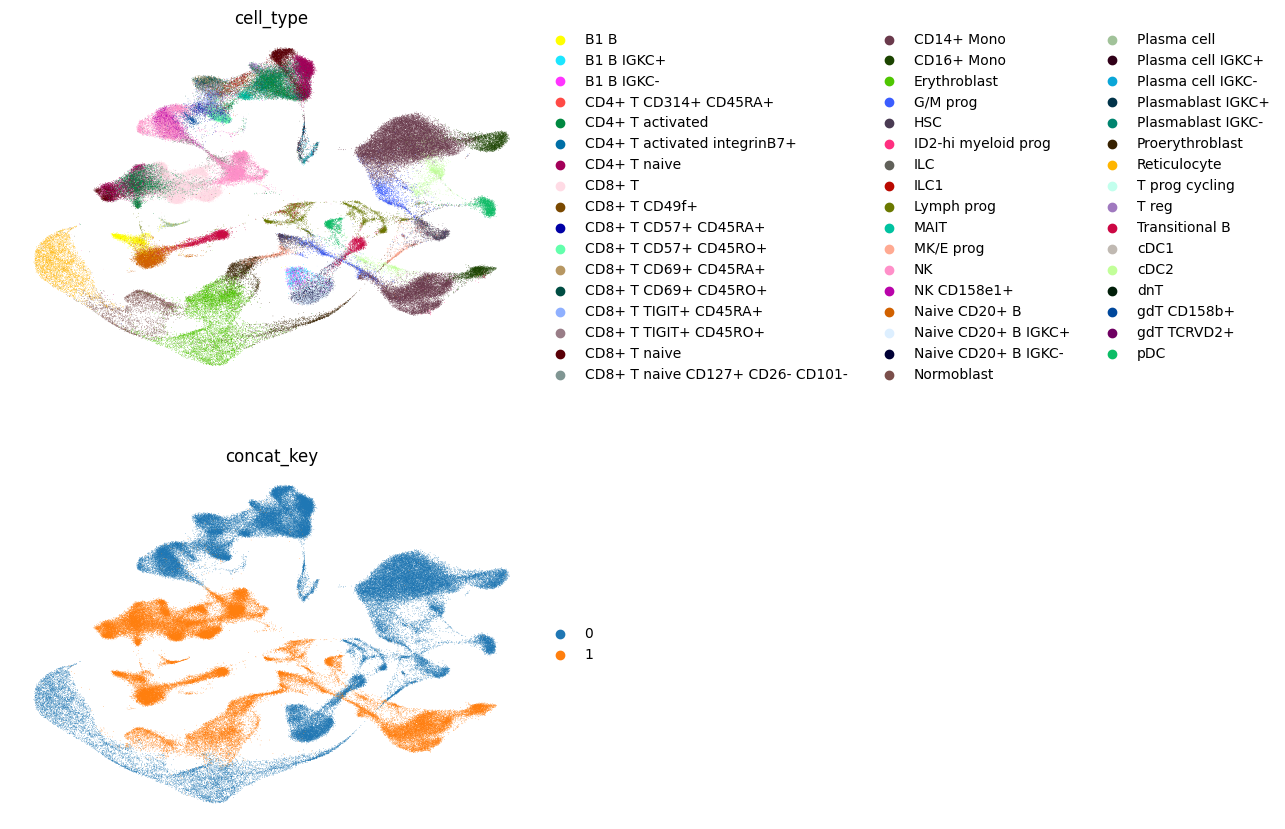

In [12]:
sc.pl.umap(rna, color=["cell_type", "concat_key"], ncols=1, frameon=False)

In [13]:
# getting back raw counts after normalizing for plotting
rna.X = rna.layers["counts"].copy()

# Preprocess ATAC

In [14]:
atac.X = atac.layers['binary'].copy()

In [ ]:
scglue.data.lsi(atac, n_components=100, n_iter=15)

In [16]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

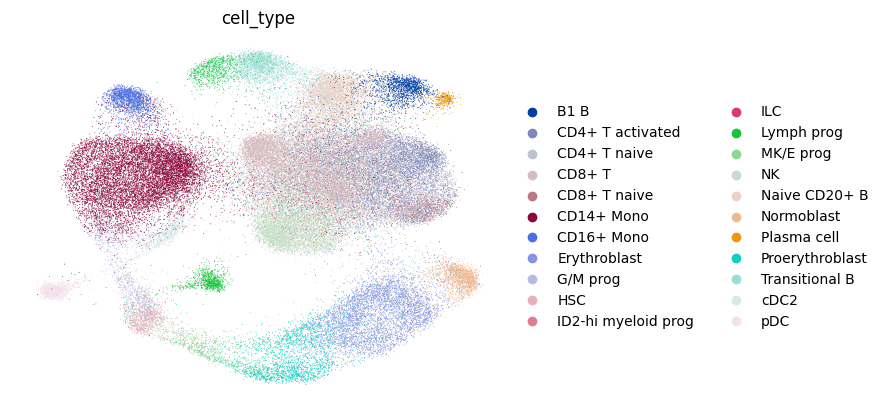

In [17]:
sc.pl.umap(atac, color="cell_type", frameon=False)

# Preprocess ADT

In [18]:
np.max(adt.X)

7.874281

In [19]:
sc.tl.pca(adt, n_comps=100, svd_solver="auto")

In [20]:
sc.pp.neighbors(adt, metric="cosine")
sc.tl.umap(adt)

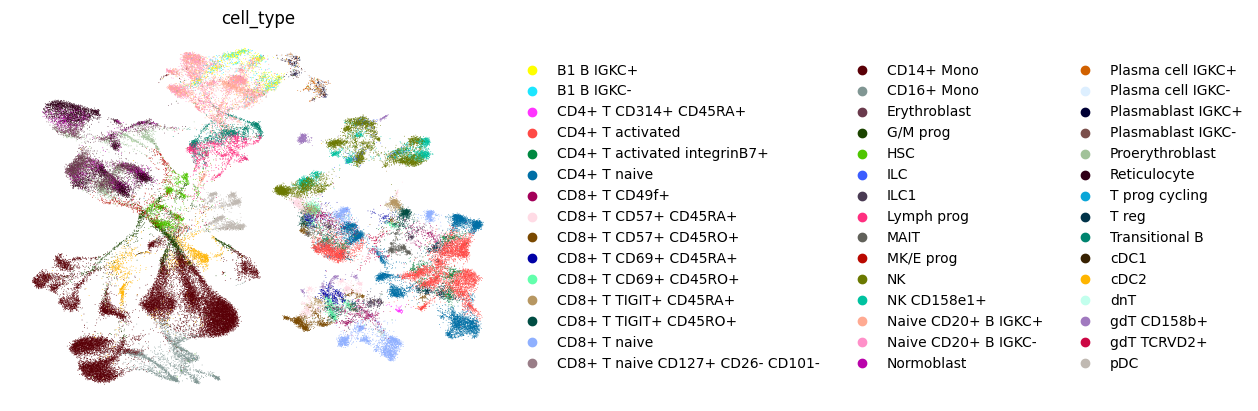

In [21]:
sc.pl.umap(adt, color="cell_type", frameon=False)

# Graph construction

## Add RNA-ATAC edges, RNA nodes and ATAC nodes

In [22]:
scglue.data.get_gene_annotation(
    rna, gtf="gencode.v42.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
ISG15,chr1,1001137.0,1014540.0
C1orf159,chr1,1081817.0,1116361.0
SLC35E2B,chr1,1659528.0,1692795.0
SLC35E2A,chr1,1734689.0,1739557.0
PRKCZ,chr1,2050410.0,2185395.0


In [23]:
rna_all = rna.copy()

In [24]:
rna = rna[:, ~rna.var["chrom"].isna()]
rna

View of AnnData object with n_obs × n_vars = 159510 × 3692
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split', 'concat_key'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean',

In [25]:
atac.var_names[:5]

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-778276-779191',
       'chr1-816868-817761', 'chr1-827067-827948'],
      dtype='object')

In [26]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,feature_types,gene_id,highly_variable,means,dispersions,dispersions_norm,chrom,chromStart,chromEnd
chr1-9776-10668,ATAC,NaN,True,0.021174,1.935881,1.505978,chr1,9776,10668
chr1-180726-181005,ATAC,NaN,True,0.023388,1.997198,1.760856,chr1,180726,181005
chr1-778276-779191,ATAC,NaN,True,0.503030,1.648333,0.883297,chr1,778276,779191
chr1-816868-817761,ATAC,NaN,True,0.034507,1.836815,1.094193,chr1,816868,817761
chr1-827067-827948,ATAC,NaN,True,0.231116,1.700894,1.100383,chr1,827067,827948


In [27]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph:   0%|          | 0/3692 [00:00<?, ?it/s]

In [28]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [29]:
edge_chr_to_gene = {}
for e in guidance.edges:
    if guidance.edges[e]['type'] == "rev":
        edge_chr_to_gene[e[0]] = e[1]

In [ ]:
atac.var.index = list(map(lambda x: x if x not in edge_chr_to_gene else edge_chr_to_gene[x], atac.var.index.tolist()))

## Add RNA-ADT

In [ ]:
adt.var_names

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=134)

In [ ]:
rna.var_names

Index(['ISG15', 'C1orf159', 'SLC35E2B', 'SLC35E2A', 'PRKCZ', 'PLCH2', 'CEP104',
       'NPHP4', 'ESPN', 'DNAJC11',
       ...
       'PLXNA3', 'GAB3', 'F8', 'BRCC3', 'CLIC2', 'TMLHE', 'MT-ND1', 'MT-ATP8',
       'MT-ATP6', 'MT-CYB'],
      dtype='object', length=3692)

In [ ]:
len(set(rna.var_names).intersection(set(adt.var_names)))

17

# Multimap

In [ ]:
import MultiMAP

In [ ]:
MultiMAP.TFIDF_LSI(atac)

In [ ]:
rna_pca = rna_all.copy()
sc.pp.scale(rna_pca)
sc.pp.pca(rna_pca)
rna_all.obsm['X_pca'] = rna_pca.obsm['X_pca'].copy()

In [ ]:
adt_pca = adt.copy()
sc.pp.scale(adt_pca)
sc.pp.pca(adt_pca)
adt.obsm['X_pca'] = adt_pca.obsm['X_pca'].copy()

In [106]:
# Multiple atac_peaks are mapped to a single gene
# non_mito_genes_list = [name for name in adata.var_names if not name.startswith('MT-')]
# adata_no_mito_genes = adata[:, non_mito_genes_list]

atac.var_names_make_unique()

In [ ]:
atac.var_names

In [ ]:
for var_name in atac.var_names.tolist():
    after_dash = var_name.rsplit("-")[-1]
    if len(after_dash) > 0 and after_dash.isdigit() and int(after_dash) < 100:
        print(var_name)

In [1]:
adata

NameError: name 'adata' is not defined

In [102]:
adata = MultiMAP.Integration([rna, adt, atac], ['X_pca', 'X_pca', 'X_lsi'])

ValueError: Data must be 1-dimensional